# Lecture 6: Particle Identification Detectors

Author: Aleksander Filip Żarnecki (University of Warsaw)

### Import libraries 

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

## Part I: Time-of-Flight detectors

In [2]:
# Time of particle propagation in uniform magnetic field
# (unit charge assumed, |q| = 1e !)

# Magnetic field [T]
B = 3.5

# Distance (IP to ToF detector) [m]
d = 1.8

# Speed of light [m/s]

c = 3E+08    

In [13]:
# Propagation time for given momentum [GeV/c] and mass [GeV/c^2]
# Assuming particle perpendicular to beam axis

def propTime(p,m) :
    
    # Particle velocity (in c units)
    
    beta = p/np.sqrt(p*p+m*m)
    
    # Curvature radius in magnetic field [m]
    
    R = p/B * 1E+09/c       # Additional numerical factor from G(eV)
    
    if R > d/2 :
        l = 2*R*np.arcsin(d/2./R)
        t = l/(beta*c)
        
    else:
        t = -1              # curvature too small

    return t

In [4]:
# Reconstruct particle mass from momentum and time

def recMass(p,t) :
    
    # Curvature radius in magnetic field [m]
    
    R = p/B * 1E+09/c       # Additional numerical factor from G(eV)
    
    # Velocity as distance over time
    
    l = 2*R*np.arcsin(d/2./R)
    beta = l/t/c
    
    mass = p * np.sqrt((1/beta/beta - 1)*(beta>0)*(beta<1))
    
    return mass

In [16]:
# Test procedure consistency

me  = 0.0005109989461  # e+
mpi = 0.13957    # pi+
mK = 0.493677    # K+
mp = 0.938272    # p

p0 = 1.0  # in GeV 

t0 = propTime(p0,mpi)

m1 = recMass(p0,t0)

print("Reconstructed test mass: ",m1," GeV")

Reconstructed test mass:  0.13956999999999967  GeV


In [6]:
# Generate multiple measurements with given measurement precision

dp = 1E-03  # Relative precision in momentum
dt = 3E-11  # Time measurement precision (30ps)

def mcGen(p,m,Nmc):

    # Actual propagation time
    
    t = propTime(p,m)
    
    # Measured values
    
    tmeas = np.random.normal(loc=t, scale=dt, size=Nmc)
    pmeas = np.random.normal(loc=p, scale=p*dp, size=Nmc)
    
    mmeas = recMass(pmeas,tmeas)
    
    return mmeas

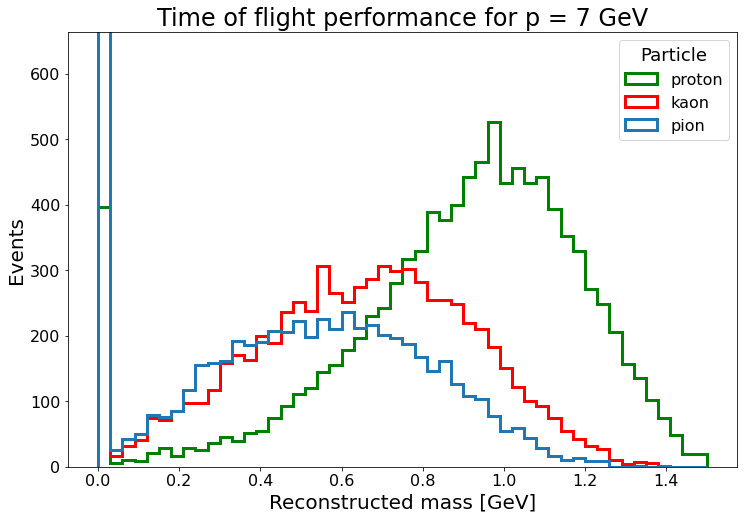

In [21]:
# Number of generations 

Nmc = 10000

# Particle momentum for comparison

p0 = 7  # in GeV

# Generate pseudo-data for three considered particles

mcpi = mcGen(p0,mpi,Nmc)
mcK = mcGen(p0,mK,Nmc)
mcp = mcGen(p0,mp,Nmc)

plt.figure(figsize=(12,8))

plt.hist(mcp,log=False,histtype='step',color='green',linewidth=3, bins=50,range=(0.,1.5),label='proton')

ymin, ymax = plt.ylim()

plt.hist(mcK,log=False,histtype='step',color='red',linewidth=3, bins=50,range=(0.,1.5),label='kaon')
plt.hist(mcpi,log=False,histtype='step',linewidth=3, bins=50,range=(0.,1.5),label='pion')

plt.ylim(ymin,1.2*ymax)

#plt.hist(xy[:,0],density=True,log=False,histtype='step',color='red',bins=50,range=(-1.,1.),label='Rejection')
         
plt.xlabel('Reconstructed mass [GeV]',size=20)
plt.ylabel('Events',size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.yticks([0,1,2],['Ground','Meta-stable','Excited'],fontsize=16)
plt.title("Time of flight performance for p = "+str(p0)+" GeV",size=24)
plt.legend(title='Particle',title_fontsize=18,fontsize=16);

fname = '06_tof_'+str(p0)+'.png'

plt.savefig(fname,format='png')

plt.show()

## Part II: Transition radiation detectors

In [8]:
# Fine coupling constant (low energy limit)

aem = 1.0/137.035999139     

# Energy corresponding to plasma frequency i radiator [eV]

hwp = 20

# Photon detection threshold  [eV]

hwth = 1000   # 1 keV , soft X-ray

# Saturation effects enter for gamma greater than

gsat = 3000


In [9]:
# Probability of radiation (above energy threshold) for single boundary transition (vacuum - radiator)
# (assuming unit particle charge |q| = e)

def muRad(gamma):

    rlog = np.log(gamma*hwp/hwth)

    mu = aem/np.pi * (np.power(rlog - 1, 2)*(rlog>0) + np.pi*np.pi/12)
    
    return mu
    

In [10]:
# Generation of expected energy sum of independent photon emissions

def radEne(gamma,Nrad):
    
    rlog = np.log(gamma*hwp/hwth)
    
    ur = np.random.uniform(0,rlog,size=Nrad)
    
    er = (rlog>0) * hwth * np.exp(ur)
    
    return np.sum(er)


In [22]:
# Expected energy loss [MeV] in for multiple layers

def mcTdr(p,m,Ntrd,Nmc):

    betagamma = p/m
    gamma = np.sqrt(1+betagamma*betagamma)

    if gamma > gsat : 
        gamma = gsat

    mu1 = muRad(gamma)         # Probability of radiation in single transition
        
    etab = np.empty(Nmc)
       
    for imc in range(Nmc):
        
        Nrad = np.random.poisson(Ntrd*mu1)

        etab[imc] = radEne(gamma,Nrad)/1E+06    # changing from eV to MeV
        
    return etab

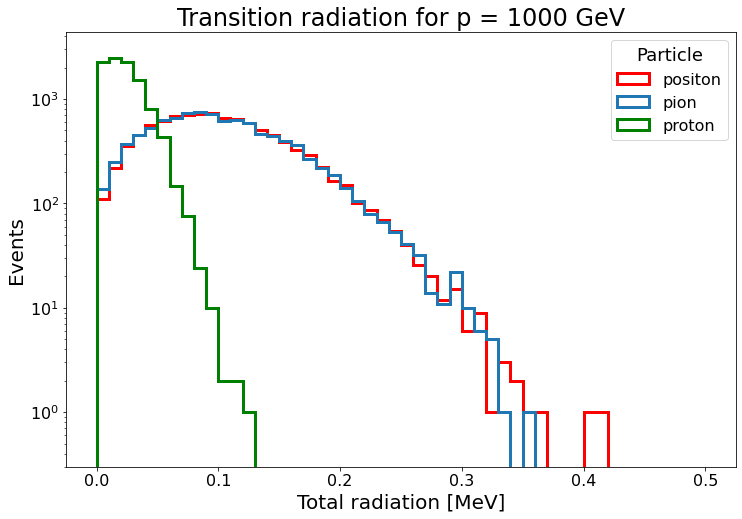

In [27]:
# Number of generations 

Nmc = 10000

# Number of Tdr layers

Ntdr = 300

# Particle momentum for comparison [GeV]

p0 = 1000

# Generate pseudo-data for considered particles

tdre = mcTdr(p0,me,Ntdr,Nmc)
tdrp = mcTdr(p0,mp,Ntdr,Nmc)
tdrpi = mcTdr(p0,mpi,Ntdr,Nmc)

# Histogram range

Emax = 0.5

plt.figure(figsize=(12,8))

plt.hist(tdre,log=True,histtype='step',color='red',linewidth=3, bins=50,range=(0.,Emax),label='positon')
plt.hist(tdrpi,log=True,histtype='step',linewidth=3, bins=50,range=(0.,Emax),label='pion')
plt.hist(tdrp,log=True,histtype='step',color='green',linewidth=3, bins=50,range=(0.,Emax),label='proton')

ymin, ymax = plt.ylim()
plt.ylim(0.3,1.2*ymax)

#plt.hist(xy[:,0],density=True,log=False,histtype='step',color='red',bins=50,range=(-1.,1.),label='Rejection')
         
plt.xlabel('Total radiation [MeV]',size=20)
plt.ylabel('Events',size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.yticks([0,1,2],['Ground','Meta-stable','Excited'],fontsize=16)
plt.title("Transition radiation for p = "+str(p0)+" GeV",size=24)
plt.legend(title='Particle',title_fontsize=18,fontsize=16);

fname = '06_tdr_'+str(p0)+'.png'

plt.savefig(fname,format='png')

plt.show()